In [11]:
from scipy.io import wavfile
import pydub
import os
import numpy as np
from PIL import Image
from pydub import AudioSegment
from pydub.utils import mediainfo
from scipy import ndimage
import matplotlib.pyplot as plt
import h5py
import time
import scipy

In [12]:
mediainfo("sounddiff/A.wav")

{'index': '0',
 'codec_name': 'pcm_mulaw',
 'codec_long_name': 'PCM mu-law / G.711 mu-law',
 'profile': 'unknown',
 'codec_type': 'audio',
 'codec_time_base': '1/8000',
 'codec_tag_string': '[7][0][0][0]',
 'codec_tag': '0x0007',
 'sample_fmt': 's16',
 'sample_rate': '8000',
 'channels': '1',
 'channel_layout': 'unknown',
 'bits_per_sample': '8',
 'id': 'N/A',
 'r_frame_rate': '0/0',
 'avg_frame_rate': '0/0',
 'time_base': '1/8000',
 'start_pts': 'N/A',
 'start_time': 'N/A',
 'duration_ts': '5468',
 'duration': '0.683500',
 'bit_rate': '64678',
 'max_bit_rate': 'N/A',
 'bits_per_raw_sample': 'N/A',
 'nb_frames': 'N/A',
 'nb_read_frames': 'N/A',
 'nb_read_packets': 'N/A',
 'DISPOSITION': {'default': '0',
  'dub': '0',
  'original': '0',
  'comment': '0',
  'lyrics': '0',
  'karaoke': '0',
  'forced': '0',
  'hearing_impaired': '0',
  'visual_impaired': '0',
  'clean_effects': '0',
  'attached_pic': '0',
  'timed_thumbnails': '0'},
 'filename': 'sounddiff/A.wav',
 'nb_streams': '1',
 'nb

In [13]:
def numpy2pil(np_array: np.ndarray) -> Image:
    """
    Convert an HxWx3 numpy array into an RGB Image
    """

    assert_msg = 'Input shall be a HxWx3 ndarray'
    assert isinstance(np_array, np.ndarray), assert_msg
    assert len(np_array.shape) == 3, assert_msg
    assert np_array.shape[2] == 3, assert_msg

    img = Image.fromarray(np_array, 'RGB')
    return img

In [14]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy

    Arguments:
    Z -- numpy array of any shape

    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """

    A = 1 / (1 + np.exp(-Z))
    cache = Z

    return A, cache

In [15]:
def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """

    A = np.maximum(0, Z)

    assert (A.shape == Z.shape)

    cache = Z
    return A, cache


In [16]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    Z = cache
    dZ = np.array(dA, copy=True)  # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well.
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ


In [17]:
def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    Z = cache

    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)

    assert (dZ.shape == Z.shape)

    return dZ

In [18]:
def load_data():
    train_data = Image.open("img/n.png")
    train_data.load()
    train_set_x_orig = np.asarray(train_data, dtype="int32")
    train_set_y_orig = np.ones([1, 852])

    classes = np.array(["n"])

    test_data = Image.open("image/n.png")
    test_data.load()
    test_set_x_orig = np.asarray(test_data, dtype="int32")
    test_set_y_orig = np.ones([1, 852])

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [19]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer

    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """

    np.random.seed(1)

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [20]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network

    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """

    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)  # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) / np.sqrt(
            layer_dims[l - 1])  # *0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

In [21]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """

    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache

In [22]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """

    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [23]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation

    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()

    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network

    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)],
                                             activation="relu")
        caches.append(cache)

    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation="sigmoid")
    caches.append(cache)

    assert (AL.shape == (1, X.shape[1]))

    return AL, caches

In [24]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """

    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1. / m) * (-np.dot(Y, np.log(AL).T) - np.dot(1 - Y, np.log(1 - AL).T))

    cost = np.squeeze(cost)  # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert (cost.shape == ())

    return cost

In [25]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1. / m * np.dot(dZ, A_prev.T)
    db = 1. / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db

In [26]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.

    Arguments:
    dA -- post-activation gradient for current layer l
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [27]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group

    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)

    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ...
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ...
    """
    grads = {}
    L = len(caches)  # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  # after this line, Y is the same shape as AL

    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L - 1]
    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,
                                                                                                      current_cache,
                                                                                                      activation="sigmoid")

    for l in reversed(range(L - 1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache,
                                                                    activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [28]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent

    Arguments:
    parameters -- python dictionary containing your parameters
    grads -- python dictionary containing your gradients, output of L_model_backward

    Returns:
    parameters -- python dictionary containing your updated parameters
                  parameters["W" + str(l)] = ...
                  parameters["b" + str(l)] = ...
    """

    L = len(parameters) // 2  # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters

In [29]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.

    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model

    Returns:
    p -- predictions for the given dataset X
    """

    m = X.shape[1]
    n = len(parameters) // 2  # number of layers in the neural network
    p = np.zeros((1, m))

    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0, i] > 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0

    # print results
    # print ("predictions: " + str(p))
    # print ("true labels: " + str(y))
    print("Accuracy: " + str(np.sum((p == y) / m)))

    return p

In [30]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0)  # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]

        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:, index].reshape(64, 64, 3), interpolation='nearest')
        plt.axis('off')
        plt.title(
            "Prediction: " + classes[int(p[0, index])].decode("utf-8") + " \n Class: " + classes[y[0, index]].decode(
                "utf-8"))
        plt.show()

In [31]:
plt.rcParams['figure.figsize'] = (7.5, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [32]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [33]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

In [34]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

n_x = 144
n_h = 7
n_y = 1

In [35]:
def two_layer_model(X, Y, layer_dims, learning_rate = 0.0075, num_iterations=3000, print_cost=False):
    grads = {}
    costs = []
    m = X.shape[0]
    (n_x, n_h, n_y) = layer_dims

    parameters = initialize_parameters(n_x, n_h, n_y)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    for i in range(num_iterations):
        A1, cache1 = linear_activation_forward(X, W1, b1, activation="relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation="sigmoid")

        cost = compute_cost(A2, Y)

        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))

        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu")

        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2

        parameters = update_parameters(parameters, grads, learning_rate)

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters
# parameters = two_layer_model(train_x, train_y, layer_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=False)

# expected:
# Cost after iteration 0: 0.6930497356599888
# Cost after iteration 100: 0.6464320953428849
# Cost after iteration 200: 0.6325140647912677
# Cost after iteration 300: 0.6015024920354665
# Cost after iteration 400: 0.5601966311605747
# Cost after iteration 500: 0.515830477276473
# Cost after iteration 600: 0.4754901313943325
# Cost after iteration 700: 0.4339163151225749
# Cost after iteration 800: 0.4007977536203887
# Cost after iteration 900: 0.3580705011323798
# Cost after iteration 1000: 0.3394281538366412
# Cost after iteration 1100: 0.3052753636196264
# Cost after iteration 1200: 0.27491377282130164
# Cost after iteration 1300: 0.24681768210614846
# Cost after iteration 1400: 0.19850735037466116
# Cost after iteration 1500: 0.1744831811255664
# Cost after iteration 1600: 0.17080762978096148
# Cost after iteration 1700: 0.11306524562164734
# Cost after iteration 1800: 0.09629426845937152
# Cost after iteration 1900: 0.08342617959726863
# Cost after iteration 2000: 0.07439078704319081
# Cost after iteration 2100: 0.0663074813226793
# Cost after iteration 2200: 0.0591932950103817
# Cost after iteration 2300: 0.053361403485605585
# Cost after iteration 2400: 0.04855478562877016

# predictions_train = predict(train_x, train_y, parameters)
# predictions_test = predict(test_x, test_y, parameters)

# expected:
# Accuracy: 0.9999999999999998
# Accuracy: 0.72


In [36]:
layer_dims = (144, 20, 7, 5, 1)

In [37]:
def L_layer_model(X, Y, layer_dims, learning_rate = 0.03, num_iterations=3000, print_cost=False):
    costs = []
    parameters = initialize_parameters_deep(layer_dims)

    for i in range(num_iterations):
        AL, caches = L_model_forward(X, parameters)

        cost = compute_cost(AL, Y)

        grads = L_model_backward(AL, Y, caches)

        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if i % 100 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.577460
Cost after iteration 100: 0.027970
Cost after iteration 200: 0.010631
Cost after iteration 300: 0.005968
Cost after iteration 400: 0.003966
Cost after iteration 500: 0.002894
Cost after iteration 600: 0.002242
Cost after iteration 700: 0.001809
Cost after iteration 800: 0.001503
Cost after iteration 900: 0.001278
Cost after iteration 1000: 0.001107
Cost after iteration 1100: 0.000972
Cost after iteration 1200: 0.000864
Cost after iteration 1300: 0.000775
Cost after iteration 1400: 0.000701
Cost after iteration 1500: 0.000639
Cost after iteration 1600: 0.000586
Cost after iteration 1700: 0.000541
Cost after iteration 1800: 0.000501
Cost after iteration 1900: 0.000466
Cost after iteration 2000: 0.000436
Cost after iteration 2100: 0.000409
Cost after iteration 2200: 0.000384
Cost after iteration 2300: 0.000362
Cost after iteration 2400: 0.000343


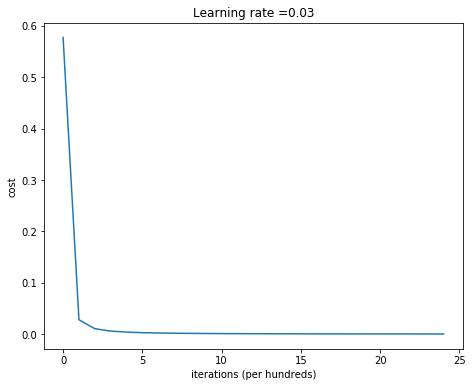

Accuracy: 0.9999999999999997
Accuracy: 0.9999999999999997


In [38]:
parameters = L_layer_model(train_x, train_y, layer_dims, num_iterations = 2500, print_cost = True)


pred_train = predict(train_x, train_y, parameters)
pred_test = predict(test_x, test_y, parameters)

In [39]:
for i in range(11): 
    strtarget = "sounds/" + str(i) + ".mp3"
    strdest = "soundwav/" + str(i) + ".wav"
    sound = pydub.AudioSegment.from_mp3(strtarget)
    sound.export(strdest, format="wav")
for i in range(65,91):
    char = chr(i)
    strtarget = "sounddiff/" + char + ".wav"
    strdest = "soundwav/" + char + ".wav"
    sound = pydub.AudioSegment.from_wav(strtarget)
    sound.export(strdest, format="wav")
    #AudioSegment.from_wav(strtarget).export(strdest, format="mp3")

CouldntDecodeError: Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

b"ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzmq --enable-libzvbi --enable-omx --enable-openal --enable-opengl --enable-sdl2 --enable-libdc1394 --enable-libdrm --enable-libiec61883 --enable-chromaprint --enable-frei0r --enable-libopencv --enable-libx264 --enable-shared\n  libavutil      55. 78.100 / 55. 78.100\n  libavcodec     57.107.100 / 57.107.100\n  libavformat    57. 83.100 / 57. 83.100\n  libavdevice    57. 10.100 / 57. 10.100\n  libavfilter     6.107.100 /  6.107.100\n  libavresample   3.  7.  0 /  3.  7.  0\n  libswscale      4.  8.100 /  4.  8.100\n  libswresample   2.  9.100 /  2.  9.100\n  libpostproc    54.  7.100 / 54.  7.100\nGuessed Channel Layout for Input Stream #0.0 : mono\nInput #0, wav, from 'sounddiff/A.wav':\n  Duration: 00:00:00.68, bitrate: 64 kb/s\n    Stream #0:0: Audio: pcm_mulaw ([7][0][0][0] / 0x0007), 8000 Hz, mono, s16, 64 kb/s\nStream mapping:\n  Stream #0:0 -> #0:0 (pcm_mulaw (native) -> pcm_s8 (native))\nPress [q] to stop, [?] for help\n[wav @ 0x5578c6345180] pcm_s8 codec not supported in WAVE format\nCould not write header for output file #0 (incorrect codec parameters ?): Function not implemented\nError initializing output stream 0:0 -- \nConversion failed!\n"

In [ ]:
#to convert numbers
for k in range(11):
    string = "soundwav/" + str(k) + ".wav"
    stringdest = "img/" + str(k) + ".png"
    fs, data = wavfile.read(string)
    length = len(data)
    h = int(length/48)
    a = np.array([])
    for i in data:
        if i>=0:
            if i>255:
                x = i
                a = np.append(a,255)
                x/=255
                if x>255:
                    a = np.append(a,255)
                    x/=255
                    a = np.append(a,int(x))
                else:
                    a = np.append(a,[int(x),0])
            else:
                a = np.append(a,[int(i),0,0])
        else:
            x = 16581375 + i
            if x>255:
                a = np.append(a,255)
                x/=255
                if x>255:
                    a = np.append(a,255)
                    x/=255
                    a = np.append(a,int(x))
                else:
                    a = np.append(a,[int(x),0])
            else:
                a = np.append(a,[int(i),0,0])
    len(a)
    a.shape = (h,48,3)
    a
    img = Image.fromarray(a,'RGB')
    img.save(stringdest)

In [ ]:
#to convert alphabets
#for k in range(97,123):
for k in range(65,91):
    string = "sounddiff/" + chr(k) + ".wav"
    stringdest = "img/" + chr(k) + ".png"
    fs, data = wavfile.read(string)
    length = len(data)
    h = int(length/48)
    a = np.array([])
    for i in data:
        if i>=0:
            if i>255:
                x = i
                a = np.append(a,255)
                x/=255
                if x>255:
                    a = np.append(a,255)
                    x/=255
                    a = np.append(a,int(x))
                else:
                    a = np.append(a,[int(x),0])
            else:
                a = np.append(a,[int(i),0,0])
        else:
            x = 16581375 + i
            if x>255:
                a = np.append(a,255)
                x/=255
                if x>255:
                    a = np.append(a,255)
                    x/=255
                    a = np.append(a,int(x))
                else:
                    a = np.append(a,[int(x),0])
            else:
                a = np.append(a,[int(i),0,0])
    len(a)
    a.shape = (h,48,3)
    a
    img = Image.fromarray(a,'RGB')
    img.save(stringdest)

In [51]:
for i in range(4,7):   
    string = "American-English/Narrative/narrative"+str(i)+".wav"
    stringdest = "img/narrative"+str(i)+".png"
    fs, data = wavfile.read(string)
    #length = len(data)
    #h = int(length/576)
    #k = length - (h*576)
    a = np.array([])
    for i in data:
        if i>=0:
            if i>255:
                x = i
                a = np.append(a,255)
                x/=255
                if x>255:
                    a = np.append(a,255)
                    x/=255
                    a = np.append(a,int(x))
                else:
                    a = np.append(a,[int(x),0])
            else:
                a = np.append(a,[int(i),0,0])
        else:
            x = 16581375 + i
            if x>255:
                a = np.append(a,255)
                x/=255
                if x>255:
                    a = np.append(a,255)
                    x/=255
                    a = np.append(a,int(x))
                else:
                    a = np.append(a,[int(x),0])
            else:
                a = np.append(a,[int(i),0,0])
    length = len(a)
    h = int(length/576)
    k = length - (h*576)
    b = a[k:]
    print(str(k)+" "+str(len(b))+" "+str(len(a))+" "+str(h)+"\n")
    b.shape = (h,192,3)
    b
    img = Image.fromarray(b,'RGB')
    img.save(stringdest)

162 131328 131490 228

459 227520 227979 395

450 240192 240642 417

